📌 Cell 1: Install / Import libraries

In [2]:
!pip install scikit-learn --quiet

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


📌 Cell 2: Load the dataset

In [66]:
CSV_PATH = "/kaggle/input/america-dengue-data/dengue data 17-07-2025.csv"  # update path

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,30-04-1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,07-05-1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,14-05-1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,21-05-1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,28-05-1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


📌 Cell 3: Parse dates and sort

In [67]:
# Convert week_start_date
df['week_start_date'] = pd.to_datetime(df['week_start_date'], format='%d-%m-%Y', errors='coerce')

def y_week_to_date(y, w):
    w = int(max(1, min(53, w)))
    return pd.to_datetime(f"{int(y)}-{w}-1", format="%G-%V-%u", errors='coerce')

if df['week_start_date'].isna().any():
    df['week_start_date'] = [
        a if pd.notna(a) else y_week_to_date(y, w)
        for a, y, w in zip(df['week_start_date'], df['year'], df['weekofyear'])
    ]

df = df.sort_values(['city', 'week_start_date']).reset_index(drop=True)


📌 Cell 4: Feature Engineering

In [68]:
# # NDVI average
# df['ndvi_mean'] = df[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].mean(axis=1)

# by_city = df.groupby('city', group_keys=False)

# # Target lags
# lag_steps = [1, 2, 3, 4, 8, 12, 24]
# for L in lag_steps:
#     df[f'y_lag_{L}'] = by_city['total_cases'].shift(L)

# # Key drivers
# key_drivers = [
#     'precipitation_amt_mm','reanalysis_relative_humidity_percent',
#     'reanalysis_specific_humidity_g_per_kg','reanalysis_air_temp_k',
#     'reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_tdtr_k',
#     'station_avg_temp_c','station_diur_temp_rng_c','station_precip_mm','ndvi_mean'
# ]

# for col in key_drivers:
#     for L in [1, 2, 4, 8]:
#         df[f'{col}_lag_{L}'] = by_city[col].shift(L)
#     for W in [4, 8, 12, 24]:
#         df[f'{col}_rollmean_{W}'] = by_city[col].rolling(W, min_periods=max(2, W//2)).mean().reset_index(level=0, drop=True)

# # Week of year cyclic
# df['sin_woy'] = np.sin(2*np.pi*(df['weekofyear']-1)/52.0)
# df['cos_woy'] = np.cos(2*np.pi*(df['weekofyear']-1)/52.0)

# # One-hot encode city
# df = pd.get_dummies(df, columns=['city'], drop_first=False)

# # Drop rows with NA from lagging
# model_df = df.dropna(subset=[c for c in df.columns if c.startswith('y_lag_')])


In [69]:
# 📌 Cell 4: Feature Engineering + Horizon Target
HORIZON = 1  # 🔹 Change this value (1, 2, 4, 8, 12...) for forecast horizon in weeks

# --- NDVI average
df['ndvi_mean'] = df[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']].mean(axis=1)

by_city = df.groupby('city', group_keys=False)

# --- Target lags (for autoregressive features)
lag_steps = [1, 2, 3, 4, 8, 12, 24]
for L in lag_steps:
    df[f'y_lag_{L}'] = by_city['total_cases'].shift(L)

# --- Create target shifted by forecast horizon
df[f'y_target_{HORIZON}'] = by_city['total_cases'].shift(-HORIZON)

# --- Key drivers (weather, climate, NDVI)
key_drivers = [
    'precipitation_amt_mm','reanalysis_relative_humidity_percent',
    'reanalysis_specific_humidity_g_per_kg','reanalysis_air_temp_k',
    'reanalysis_avg_temp_k','reanalysis_dew_point_temp_k','reanalysis_tdtr_k',
    'station_avg_temp_c','station_diur_temp_rng_c','station_precip_mm','ndvi_mean'
]

for col in key_drivers:
    for L in [1, 2, 4, 8]:
        df[f'{col}_lag_{L}'] = by_city[col].shift(L)
    for W in [4, 8, 12, 24]:
        df[f'{col}_rollmean_{W}'] = by_city[col].rolling(W, min_periods=max(2, W//2)).mean().reset_index(level=0, drop=True)

# --- Week of year cyclic encoding
df['sin_woy'] = np.sin(2*np.pi*(df['weekofyear']-1)/52.0)
df['cos_woy'] = np.cos(2*np.pi*(df['weekofyear']-1)/52.0)

# --- One-hot encode city
df = pd.get_dummies(df, columns=['city'], drop_first=False)

# --- Drop rows with NA (from lagging and shifting)
model_df = df.dropna(subset=[f'y_target_{HORIZON}']).reset_index(drop=True)

print(f"✅ Feature engineering complete. Forecast horizon set to {HORIZON} weeks ahead.")


✅ Feature engineering complete. Forecast horizon set to 1 weeks ahead.


📌 Cell 5: Outlier Removal + Feature Selection + Train/Test Split

Selected features (top 15):
['y_target_1', 'y_lag_1', 'y_lag_2', 'station_diur_temp_rng_c_lag_4', 'station_diur_temp_rng_c_lag_2', 'y_lag_3', 'y_lag_4', 'precipitation_amt_mm_lag_4', 'reanalysis_relative_humidity_percent_lag_4', 'station_precip_mm_lag_1', 'station_avg_temp_c', 'reanalysis_relative_humidity_percent_lag_8', 'station_diur_temp_rng_c_lag_8', 'reanalysis_tdtr_k_lag_4', 'reanalysis_air_temp_k_lag_4']


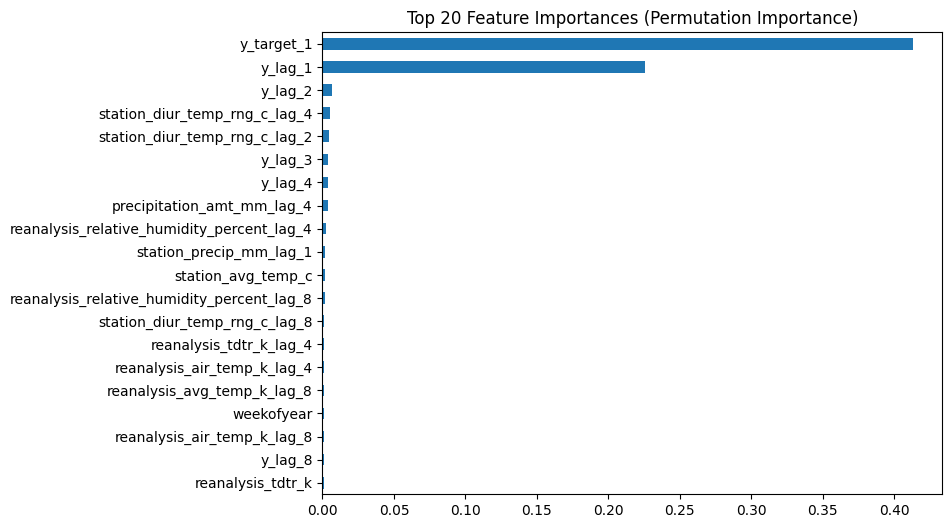

In [70]:
from sklearn.inspection import permutation_importance

# --- Outlier removal per city (IQR method)
def remove_outliers_iqr(df, col="total_cases"):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

model_df_clean = []
for c in [c.replace('city_', '') for c in df.columns if c.startswith('city_')]:
    mask = model_df[f'city_{c}'] == 1
    cleaned = remove_outliers_iqr(model_df[mask])
    model_df_clean.append(cleaned)

model_df = pd.concat(model_df_clean).sort_index().reset_index(drop=True)

# --- Train/test split: last 52 weeks per city
cities = [c.replace('city_', '') for c in df.columns if c.startswith('city_')]

train_idx, test_idx = [], []
for c in cities:
    mask_city = model_df[f'city_{c}'] == 1
    idx_city = model_df[mask_city].index
    n_test = min(52, len(idx_city))
    train_idx.extend(list(idx_city[:-n_test]))
    test_idx.extend(list(idx_city[-n_test:]))

train_df = model_df.loc[sorted(train_idx)].copy()
test_df  = model_df.loc[sorted(test_idx)].copy()

drop_cols = ['total_cases', 'week_start_date']
X_train_full, y_train = train_df.drop(columns=drop_cols), train_df['total_cases']
X_test_full, y_test   = test_df.drop(columns=drop_cols), test_df['total_cases']

# --- Feature selection with permutation importance
tmp_model = HistGradientBoostingRegressor(random_state=42)
tmp_model.fit(X_train_full, y_train)

# Permutation importance (on validation/test set)
perm = permutation_importance(tmp_model, X_test_full, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importances = pd.Series(perm.importances_mean, index=X_test_full.columns)
top_features = importances.sort_values(ascending=False).head(40).index  # top 40

X_train, X_test = X_train_full[top_features], X_test_full[top_features]

print("Selected features (top 15):")
print(list(top_features)[:15])

# --- Plot feature importances
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(8,6))
plt.title("Top 20 Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()
plt.show()


📌 Cell 6: Train Final Model

In [71]:
model = HistGradientBoostingRegressor(
    # learning_rate=0.06,
    learning_rate=0.1,
    max_depth=None,
    max_iter=1000,
    # max_iter=900,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


📌 Cell 7: Metrics

In [72]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = (np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-6)).mean() * 100

print("Performance with Outlier Removal & Feature Selection:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape:.2f}%")


Performance with Outlier Removal & Feature Selection:
RMSE: 4.894
MAE: 3.577
MAPE: 16945099.60%


📌 Cell 8: Plot Results

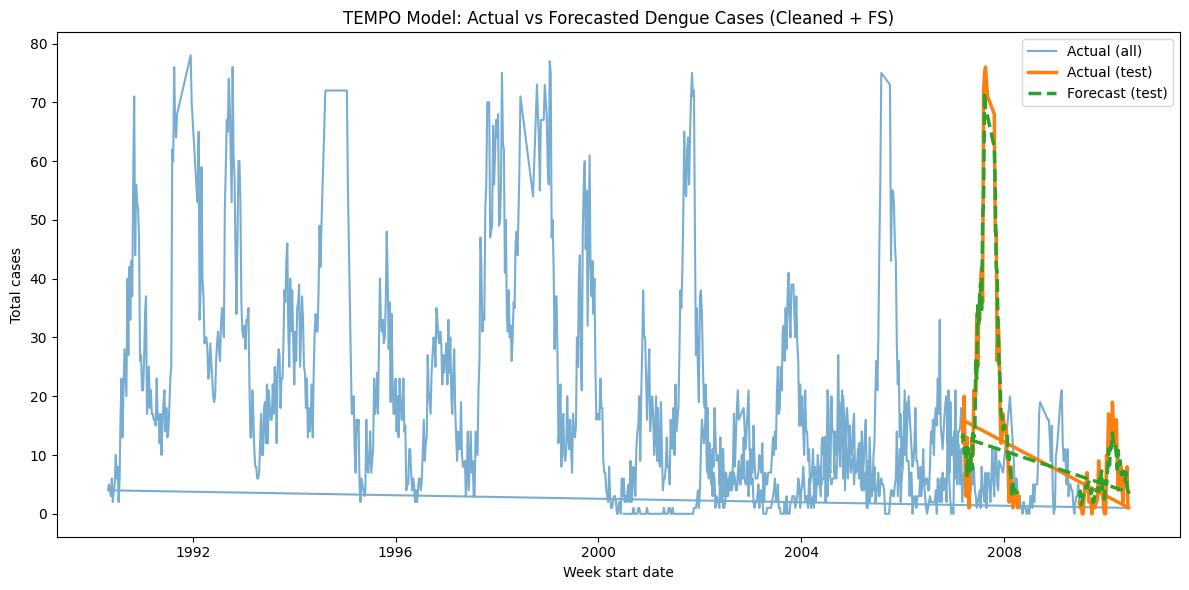

In [73]:
plot_cols = ['week_start_date'] + [c for c in model_df.columns if c.startswith('city_')]

full_plot = model_df[['total_cases'] + plot_cols].copy()
full_plot['split'] = 'train'
full_plot.loc[test_df.index, 'split'] = 'test'

full_plot['prediction'] = np.nan
full_plot.loc[test_df.index, 'prediction'] = y_pred

plt.figure(figsize=(12,6))

plt.plot(full_plot['week_start_date'], full_plot['total_cases'], label='Actual (all)', alpha=0.6)
plt.plot(full_plot.loc[full_plot['split']=='test', 'week_start_date'],
         full_plot.loc[full_plot['split']=='test', 'total_cases'], linewidth=2.5, label='Actual (test)')
plt.plot(full_plot.loc[full_plot['split']=='test', 'week_start_date'],
         full_plot.loc[full_plot['split']=='test', 'prediction'], linewidth=2.5, linestyle='--', label='Forecast (test)')

plt.title('TEMPO Model: Actual vs Forecasted Dengue Cases (Cleaned + FS)')
plt.xlabel('Week start date')
plt.ylabel('Total cases')
plt.legend()
plt.tight_layout()
plt.show()


# 📌 Cell 6: Train + Forecast city-wise

In [74]:
# 📌 Cell 6: Train + Forecast city-wise

models = {}
preds = {}
metrics = {}

for c in cities:  # cities list already created in Cell 5
    print(f"\n🔹 Training model for city: {c.upper()}")

    # Split city-specific train/test
    X_train_city = X_train[train_df[f'city_{c}'] == 1]
    y_train_city = y_train[train_df[f'city_{c}'] == 1]
    X_test_city  = X_test[test_df[f'city_{c}'] == 1]
    y_test_city  = y_test[test_df[f'city_{c}'] == 1]

    # Train model
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X_train_city, y_train_city)

    # Predict
    y_pred_city = model.predict(X_test_city)

    # Save
    models[c] = model
    preds[c] = pd.DataFrame({
        "date": test_df.loc[test_df[f'city_{c}']==1, 'week_start_date'],
        "y_true": y_test_city.values,
        "y_pred": y_pred_city
    }).reset_index(drop=True)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test_city, y_pred_city))
    mae = mean_absolute_error(y_test_city, y_pred_city)
    mape = (np.abs(y_test_city - y_pred_city) / (np.abs(y_test_city) + 1e-6)).mean() * 100

    metrics[c] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}
    print(f"  RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.1f}%")



🔹 Training model for city: IQ
  RMSE=3.22, MAE=2.61, MAPE=27219189.7%

🔹 Training model for city: SJ
  RMSE=6.37, MAE=4.82, MAPE=52.9%


# 📌 Cell 7: Plot forecasts separately

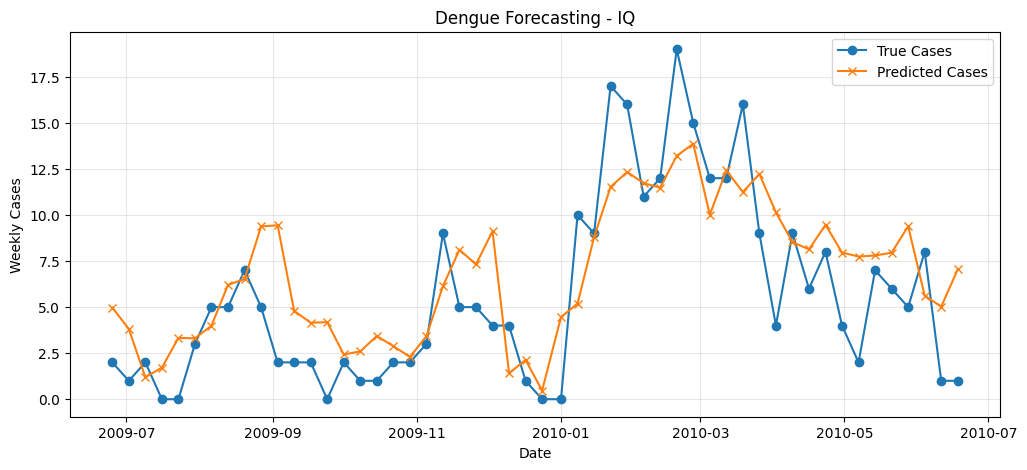

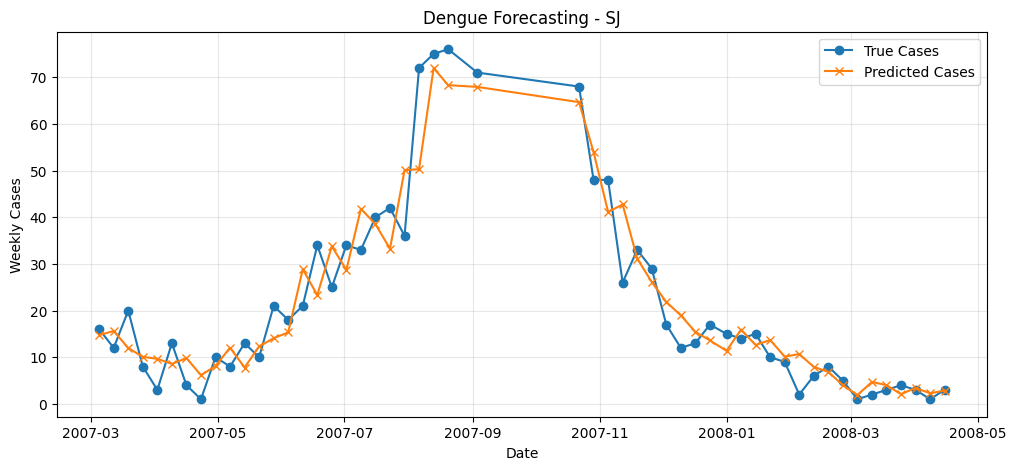

In [75]:
# 📌 Cell 7: Plot forecasts separately

for c in cities:
    df_plot = preds[c]

    plt.figure(figsize=(12,5))
    plt.plot(df_plot["date"], df_plot["y_true"], label="True Cases", marker='o')
    plt.plot(df_plot["date"], df_plot["y_pred"], label="Predicted Cases", marker='x')

    plt.title(f"Dengue Forecasting - {c.upper()}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Cases")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


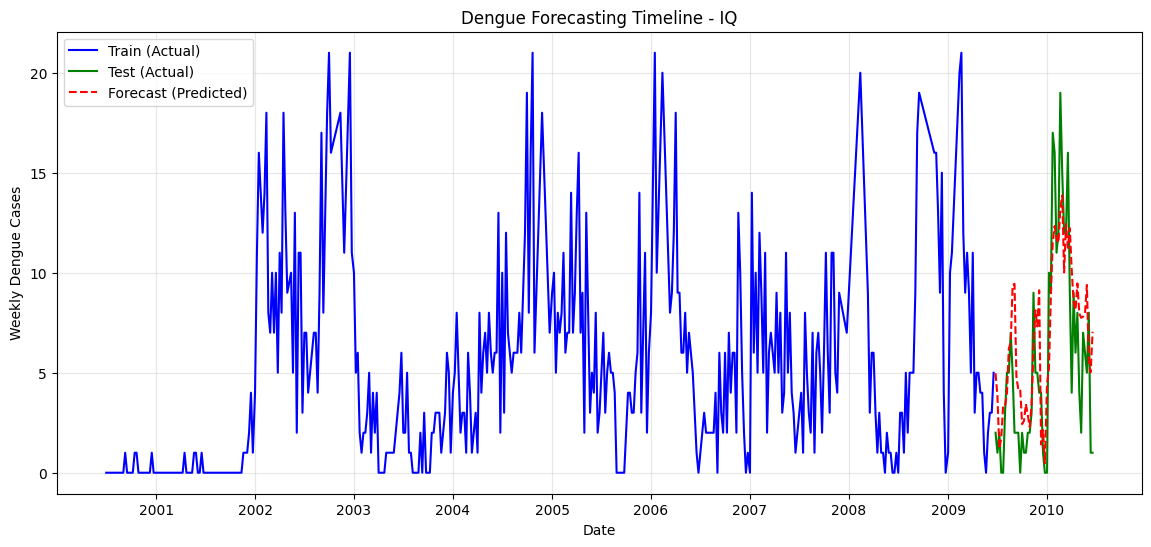

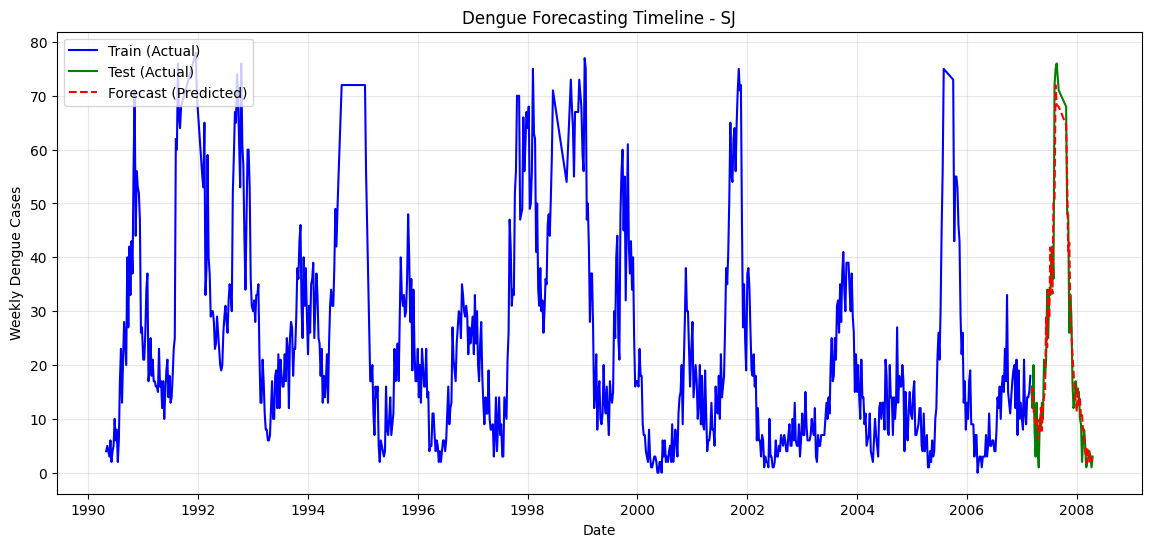

In [76]:
# 📌 Cell 7: Plot train vs test vs forecast per city

for c in cities:
    # Training part
    train_part = train_df[train_df[f'city_{c}']==1][['week_start_date','total_cases']]
    test_part  = test_df[test_df[f'city_{c}']==1][['week_start_date','total_cases']]
    pred_part  = preds[c]

    plt.figure(figsize=(14,6))
    
    # Actual train data
    plt.plot(train_part['week_start_date'], train_part['total_cases'], 
             label="Train (Actual)", color="blue")
    
    # Actual test data
    plt.plot(test_part['week_start_date'], test_part['total_cases'], 
             label="Test (Actual)", color="green")
    
    # Forecasted (predicted) test data
    plt.plot(pred_part['date'], pred_part['y_pred'], 
             label="Forecast (Predicted)", color="red", linestyle="--")

    plt.title(f"Dengue Forecasting Timeline - {c.upper()}")
    plt.xlabel("Date")
    plt.ylabel("Weekly Dengue Cases")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# 📌 Cell 8: Compare metrics

In [77]:
# 📌 Cell 8: Compare metrics

metrics_df = pd.DataFrame(metrics).T
print("\n📊 Model performance per city:")
print(metrics_df)



📊 Model performance per city:
        RMSE       MAE          MAPE
iq  3.224944  2.614214  2.721919e+07
sj  6.365728  4.817378  5.294619e+01
